✓ requests already installed
✓ geopandas already installed
✓ folium already installed
✓ matplotlib already installed
✓ pandas already installed
✓ shapely already installed
✓ contextily already installed
✓ arcgis already installed
🚀 EIA ArcGIS Data Explorer initialized!

Available methods:
- explorer.discover_datasets() - Find available datasets
- explorer.get_supported_formats(dataset_id) - Check supported formats
- explorer.download_dataset(dataset_id, format_type) - Download data
- explorer.visualize_dataset(file_path, dataset_id) - Visualize data

EXAMPLE USAGE
🔍 Discovering available EIA datasets...
Found 145 datasets

1. Solar Resources
   ID: https://www.arcgis.com/home/item.html?id=b3be0d7de6fa429d815a906aba84c4d7&sublayer=0
   Description: <span style='color:rgb(34, 34, 34); font-family:Roboto, &quot;Helvetica Neue&quot;, Helvetica, sans-...
Error discovering datasets: 'dict' object is not callable
🔍 Using alternative discovery method...
✓ Found: power_plants
✓ Found: transmiss

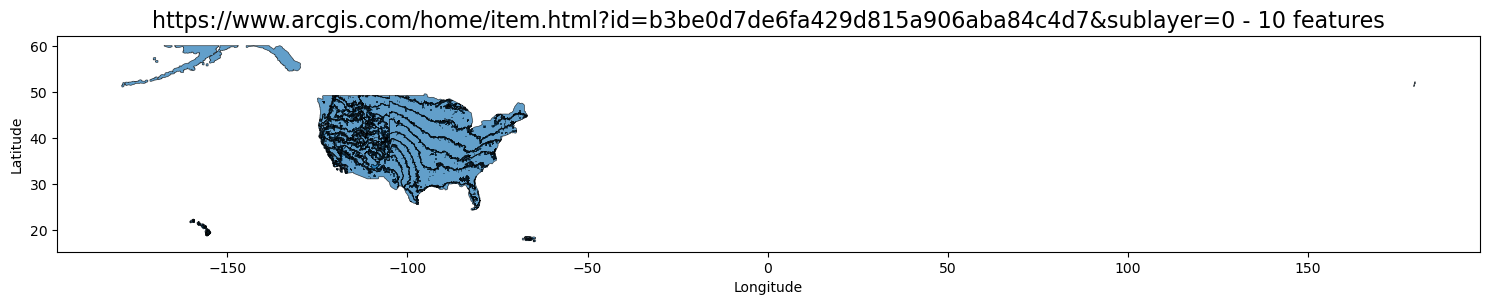

✅ Visualization completed successfully!
📍 Interactive map created (scroll down to see it)

NEXT STEPS
1. Run: datasets = explorer.discover_datasets()
2. Choose a dataset ID from the results
3. Run: file_path = explorer.download_dataset('dataset_id', 'GeoJSON')
4. Run: map_viz = explorer.visualize_dataset(file_path, 'dataset_id')
5. The map_viz object will be an interactive Folium map you can explore!


In [45]:
# EIA ArcGIS Maps and Data Explorer
# This notebook helps you discover, download, and visualize EIA energy infrastructure data

# First, let's install required packages
import subprocess
import sys

def install_packages():
    packages = [
        'requests',
        'geopandas',
        'folium',
        'matplotlib',
        'pandas',
        'shapely',
        'contextily',
        'arcgis'
    ]
    
    for package in packages:
        try:
            __import__(package)
            print(f"✓ {package} already installed")
        except ImportError:
            print(f"Installing {package}...")
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

install_packages()

# Import necessary libraries
import requests
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import json
from pathlib import Path
import urllib.parse
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
import warnings
warnings.filterwarnings('ignore')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

class EIADataExplorer:
    """
    A class to explore and download EIA ArcGIS energy infrastructure data
    """
    
    def __init__(self):
        self.base_url = "https://atlas-eia.opendata.arcgis.com"
        self.services_url = f"{self.base_url}/data.json"
        self.gis = GIS()
        self.available_datasets = {}
        
    def discover_datasets(self):
        """
        Discover available datasets from the EIA ArcGIS portal
        """
        print("🔍 Discovering available EIA datasets...")
        
        try:
            # Get the data catalog
            response = requests.get(self.services_url)
            if response.status_code == 200:
                data = response.json()
                
                # Extract dataset information
                datasets = data.get('dataset', [])
                print(f"Found {len(datasets)} datasets")
                
                for i, dataset in enumerate(datasets):
                    title = dataset.get('title', 'Unknown')
                    identifier = dataset.get('identifier', '')
                    description = dataset.get('description', 'No description available')
                    
                    self.available_datasets[identifier] = {
                        'title': title,
                        'description': description,
                        'data': dataset
                    }
                    
                    print(f"\n{i+1}. {title}")
                    print(f"   ID: {identifier}")
                    print(f"   Description: {description[:100]}...")
                    
                    # Check for download formats
                    distributions = dataset.get('distribution', [])
                    formats = [d.get('format', 'Unknown') for d in distributions]
                    if formats:
                        print(f"   Available formats: {', '.join(set(formats))}")
                
                return self.available_datasets
                
        except Exception as e:
            print(f"Error discovering datasets: {e}")
            return self._discover_datasets_alternative()
    
    def _discover_datasets_alternative(self):
        """
        Alternative method to discover datasets by searching common energy infrastructure layers
        """
        print("🔍 Using alternative discovery method...")
        
        # Common EIA layer names and their service URLs
        common_layers = {
            'power_plants': 'https://services7.arcgis.com/FGr1D95XCGALIdra/arcgis/rest/services/Power_Plants_US_EIA/FeatureServer/0',
            'transmission_lines': 'https://services7.arcgis.com/FGr1D95XCGALIdra/arcgis/rest/services/US_Electric_Power_Transmission_Lines/FeatureServer/0',
            'natural_gas_pipelines': 'https://services7.arcgis.com/FGr1D95XCGALIdra/arcgis/rest/services/Natural_Gas_Interstate_and_Intrastate_Pipelines/FeatureServer/0',
            'refineries': 'https://services7.arcgis.com/FGr1D95XCGALIdra/arcgis/rest/services/Petroleum_Refineries_US_EIA/FeatureServer/0',
            'coal_mines': 'https://services7.arcgis.com/FGr1D95XCGALIdra/arcgis/rest/services/Coal_Mines_US_EIA/FeatureServer/0',
            'lng_terminals': 'https://services7.arcgis.com/FGr1D95XCGALIdra/arcgis/rest/services/LNG_Import_Export_Terminals/FeatureServer/0'
        }
        
        for layer_name, service_url in common_layers.items():
            try:
                # Try to access the service info
                info_url = f"{service_url}?f=json"
                response = requests.get(info_url)
                
                if response.status_code == 200:
                    info = response.json()
                    
                    self.available_datasets[layer_name] = {
                        'title': info.get('name', layer_name),
                        'description': info.get('description', 'EIA energy infrastructure data'),
                        'service_url': service_url,
                        'geometry_type': info.get('geometryType', 'Unknown'),
                        'fields': info.get('fields', [])
                    }
                    
                    print(f"✓ Found: {layer_name}")
                    
            except Exception as e:
                print(f"✗ Could not access {layer_name}: {e}")
        
        return self.available_datasets
    
    def get_supported_formats(self, dataset_id):
        """
        Get supported download formats for a specific dataset
        """
        if dataset_id not in self.available_datasets:
            print(f"Dataset {dataset_id} not found")
            return []
        
        # Common ArcGIS service formats
        formats = [
            'GeoJSON',
            'ZIP', #Shapefile
            'KML',
            'CSV',
            'ArcGIS Hub Dataset',
            'ArcGIS GeoService'
        ]
        
        print(f"Supported formats for {dataset_id}:")
        for fmt in formats:
            print(f"  - {fmt}")
        
        return formats
    
    def download_dataset(self, dataset_id, format_type='GeoJSON', output_dir='./data'):
        """
        Download a dataset in the specified format
        
        Args:
            dataset_id: The dataset identifier
            format_type: Format to download (GeoJSON, Shapefile, KML, CSV, etc.)
            output_dir: Directory to save the downloaded data
        """
        if dataset_id not in self.available_datasets:
            print(f"Dataset {dataset_id} not found")
            return None
        
        # Create output directory
        Path(output_dir).mkdir(exist_ok=True)
        
        dataset = self.available_datasets[dataset_id]
        print(f"debug download_dataset = {dataset}")

        import json

        # Assuming your JSON is loaded into the variable 'dataset'
        service_url = next(
            (dist["accessURL"] for dist in dataset["data"]["distribution"] if dist.get("title").upper() == format_type.upper()),
            None
        )
        
        print(f"DEBUG service_url = {service_url}")
        try:
            # Try to use the service URL if available
            if service_url:
                filename_to_save = dataset["title"].replace(" ", "")
                print(f"DEBUG filename to save as = {filename_to_save}")
                # Download based on format
                if format_type.upper() == 'GEOJSON':
                    return self._download_geojson(service_url, filename_to_save, output_dir)
                elif format_type.upper() == 'SHAPEFILE':
                    return self._download_shapefile(service_url, filename_to_save, output_dir)
                elif format_type.upper() == 'KML':
                    return self._download_kml(service_url, filename_to_save, output_dir)
                elif format_type.upper() == 'CSV':
                    return self._download_csv(service_url, filename_to_save, output_dir)
            else:
                print(f"DEBUG service_url not in dataset")
                    
        except Exception as e:
            print(f"Error downloading {dataset_id}: {e}")
            return None
    
    def _download_geojson(self, service_url, dataset_id, output_dir):
        """Download data as GeoJSON"""
        print(f"📥 Downloading {dataset_id} as GeoJSON...")
        
        # Query all features
        query_url = f"{service_url}"
        print(f"DEBUG query_url = {query_url}")
        response = requests.get(query_url)
        
        if response.status_code == 200:
            output_file = Path(output_dir) / f"{dataset_id}.geojson"
            with open(output_file, 'w') as f:
                f.write(response.text)
            
            print(f"✓ Downloaded: {output_file}")
            return str(output_file)
        else:
            print(f"✗ Failed to download: {response.status_code}")
            return None
    
    def _download_shapefile(self, service_url, dataset_id, output_dir):
        """Download data as Shapefile"""
        print(f"📥 Downloading {dataset_id} as Shapefile...")
        
        # First get as GeoJSON, then convert to Shapefile
        geojson_file = self._download_geojson(service_url, dataset_id, output_dir)
        
        if geojson_file:
            try:
                # Read GeoJSON and save as Shapefile
                gdf = gpd.read_file(geojson_file)
                output_file = Path(output_dir) / f"{dataset_id}.shp"
                gdf.to_file(output_file)
                
                print(f"✓ Converted to Shapefile: {output_file}")
                return str(output_file)
            except Exception as e:
                print(f"✗ Error converting to Shapefile: {e}")
                return geojson_file
        
        return None
    
    def _download_kml(self, service_url, dataset_id, output_dir):
        """Download data as KML"""
        print(f"📥 Downloading {dataset_id} as KML...")
        
        # First get as GeoJSON, then convert to KML
        geojson_file = self._download_geojson(service_url, dataset_id, output_dir)
        
        if geojson_file:
            try:
                # Read GeoJSON and save as KML
                gdf = gpd.read_file(geojson_file)
                output_file = Path(output_dir) / f"{dataset_id}.kml"
                gdf.to_file(output_file, driver='KML')
                
                print(f"✓ Converted to KML: {output_file}")
                return str(output_file)
            except Exception as e:
                print(f"✗ Error converting to KML: {e}")
                return geojson_file
        
        return None
    
    def _download_csv(self, service_url, dataset_id, output_dir):
        """Download data as CSV"""
        print(f"📥 Downloading {dataset_id} as CSV...")
        
        # Query all features without geometry
        query_url = f"{service_url}"
        params = {}
        response = requests.get(query_url)
        
        if response.status_code == 200:
            data = response.json()
            features = data.get('features', [])
            
            if features:
                # Convert to DataFrame
                records = [feature['attributes'] for feature in features]
                df = pd.DataFrame(records)
                
                output_file = Path(output_dir) / f"{dataset_id}.csv"
                df.to_csv(output_file, index=False)
                
                print(f"✓ Downloaded: {output_file}")
                return str(output_file)
        
        print(f"✗ Failed to download CSV")
        return None
    
    def visualize_dataset(self, dataset_file, dataset_id):
        """
        Visualize a downloaded dataset
        """
        print(f"🗺️ Visualizing {dataset_id}...")
        
        try:
            # Read the data
            if dataset_file.endswith('.geojson') or dataset_file.endswith('.shp'):
                gdf = gpd.read_file(dataset_file)
            elif dataset_file.endswith('.csv'):
                df = pd.read_csv(dataset_file)
                print(f"CSV contains {len(df)} records")
                print(f"Columns: {list(df.columns)}")
                return df.head()
            else:
                print(f"Unsupported file format for visualization")
                return None
            
            print(f"Loaded {len(gdf)} features")
            print(f"Geometry type: {gdf.geom_type.iloc[0] if len(gdf) > 0 else 'Unknown'}")
            print(f"Coordinate Reference System: {gdf.crs}")
            
            # Create static plot
            fig, ax = plt.subplots(1, 1, figsize=(15, 10))
            gdf.plot(ax=ax, alpha=0.7, edgecolor='black', linewidth=0.5)
            ax.set_title(f"{dataset_id} - {len(gdf)} features", fontsize=16)
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
            plt.tight_layout()
            plt.show()
            
            # Create interactive map
            if len(gdf) > 0:
                # Convert to WGS84 for folium
                gdf_wgs84 = gdf.to_crs(epsg=4326)
                
                # Calculate center
                bounds = gdf_wgs84.bounds
                center_lat = (bounds.miny.min() + bounds.maxy.max()) / 2
                center_lon = (bounds.minx.min() + bounds.maxx.max()) / 2
                
                # Create folium map
                m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
                
                # Add data to map
                if gdf_wgs84.geom_type.iloc[0] == 'Point':
                    for idx, row in gdf_wgs84.iterrows():
                        folium.CircleMarker(
                            location=[row.geometry.y, row.geometry.x],
                            radius=5,
                            popup=f"{dataset_id} - Feature {idx}",
                            fillColor='red',
                            color='black',
                            weight=1,
                            fillOpacity=0.7
                        ).add_to(m)
                else:
                    folium.GeoJson(
                        gdf_wgs84,
                        style_function=lambda x: {
                            'fillColor': 'blue',
                            'color': 'black',
                            'weight': 2,
                            'fillOpacity': 0.7
                        }
                    ).add_to(m)
                
                return m
            
        except Exception as e:
            print(f"Error visualizing dataset: {e}")
            return None

# Initialize the explorer
explorer = EIADataExplorer()

print("🚀 EIA ArcGIS Data Explorer initialized!")
print("\nAvailable methods:")
print("- explorer.discover_datasets() - Find available datasets")
print("- explorer.get_supported_formats(dataset_id) - Check supported formats")
print("- explorer.download_dataset(dataset_id, format_type) - Download data")
print("- explorer.visualize_dataset(file_path, dataset_id) - Visualize data")

# Example usage
print("\n" + "="*50)
print("EXAMPLE USAGE")
print("="*50)

# Discover datasets
datasets = explorer.discover_datasets()

if datasets:
    print(f"\n📊 Found {len(datasets)} datasets")
    
    # Show available formats for first dataset
    first_dataset = list(datasets.keys())[0]
    print(f"\n🔍 Checking formats for: {first_dataset}")
    formats = explorer.get_supported_formats(first_dataset)
    
    print(f"\n💾 Example: Download {first_dataset} as GeoJSON")
    print(f"file_path = explorer.download_dataset('{first_dataset}', 'GeoJSON')")
    print(f"map_viz = explorer.visualize_dataset(file_path, '{first_dataset}')")
    
    # Try to download and visualize the first dataset
    try:
        print(f"\n🏃 Attempting to download and visualize {first_dataset}...")
        file_path = explorer.download_dataset(first_dataset, 'GeoJSON')
        
        if file_path:
            viz_result = explorer.visualize_dataset(file_path, first_dataset)
            if viz_result:
                print("✅ Visualization completed successfully!")
                
                # If it's a folium map, display it
                if hasattr(viz_result, '_repr_html_'):
                    print("📍 Interactive map created (scroll down to see it)")
                    viz_result
        
    except Exception as e:
        print(f"⚠️ Example failed: {e}")
        print("This is normal - try running the methods individually")

print("\n" + "="*50)
print("NEXT STEPS")
print("="*50)
print("1. Run: datasets = explorer.discover_datasets()")
print("2. Choose a dataset ID from the results")
print("3. Run: file_path = explorer.download_dataset('dataset_id', 'GeoJSON')")
print("4. Run: map_viz = explorer.visualize_dataset(file_path, 'dataset_id')")
print("5. The map_viz object will be an interactive Folium map you can explore!")

In [42]:
dataset_id= "https://www.arcgis.com/home/item.html?id=b3be0d7de6fa429d815a906aba84c4d7&sublayer=0"
dataset = explorer.available_datasets[dataset_id]
service_url = next(
    (dist["accessURL"] for dist in dataset["data"]["distribution"] if dist.get("format") == "geoJSON"),
    None
)
print(f"service_url = {service_url}")

KeyError: 'https://www.arcgis.com/home/item.html?id=b3be0d7de6fa429d815a906aba84c4d7&sublayer=0'

In [44]:
for dist in dataset["data"]["distribution"]:
    if dist.get("format").upper() == "GEOJSON":
        print(set["accessURL"])

https://atlas-eia.opendata.arcgis.com/datasets/eia::solar-resources
